<a href="https://colab.research.google.com/github/vivificationLeslie/TiltedIllusion/blob/master/Tilted_Illusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
### Set up

In [ ]:
import os
import numpy as np
from scipy.stats import zscore
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib as mpl
from matplotlib import pyplot as plt
import torch
# from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE




---
## Dataset Generation 

Orientation Discrimination Task

1. grating+inducer images generation

2. image labeling

3. visualization


### image generation

In [ ]:
def grating(angle, sf=1 / 28, wpix = 640, hpix = 640, res=0.1, patch=False):
  """Generate oriented grating stimulus

  Args:
    angle (float): orientation of grating, angle from vertical in radians
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.
  
  Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

  """

  # wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0
  
  xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)
  
  if patch:
    gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
    #gratings[gratings < 0] = 0  # square sine wave
    #gratings[gratings > 0] = 1
    xcent = gratings.shape[1] * .75
    ycent = gratings.shape[0] / 2
    xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
    icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res # ???
    gratings[~icirc] = 0.5
  
  else:
    gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
    # gratings[gratings < 0] = 0
    # gratings[gratings > 0] = 1

  # Return torch tensor
  return torch.tensor(gratings, dtype=torch.float32)

# ------------------------ circular aperture ------------------------------------
def gen_patch(img, pr, flip = False):

  patch = np.zeros(img.shape)    
  center = [img.shape[0]//2, img.shape[1]//2]

  # print(center)
  for i in range(patch.shape[0]):
    for j in range(patch.shape[1]):
      if ((i - center[0])**2 + (j - center[1])**2 < pr**2):
        patch[i, j] = 1
  
  if flip is True:
    patch = 1 - patch
  
  return np.multiply(img, patch)

# ------------------------ Center surround structure ---------------------------

def gen_stim(ori_out, ori_in, sf=1/28, wpix=640, hpix=640, res=0.1):

  stim_out = grating(ori_out, sf=sf, wpix=wpix, hpix=hpix, res=res)
  stim_in = grating(ori_in, sf=sf, wpix=wpix, hpix=hpix, res=res)

  r1 = stim_out.shape[0]/2
  r2 = stim_in.shape[0]/4

  stim_out_p = gen_patch(stim_out, r1)
  stim_out_pp = gen_patch(stim_out_p, r2, flip = True)
  stim_in_p = gen_patch(stim_in, r2)

  return (stim_out_pp + stim_in_p).type(torch.float32)



### image visualization

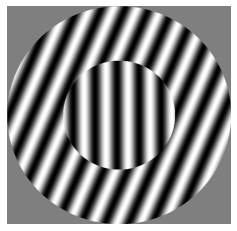

stimulus size: 64 x 64


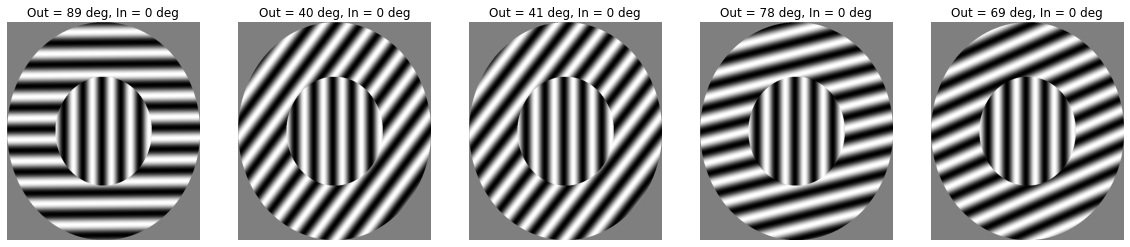

In [ ]:
def show_stimulus(img, ax=None):
  """Visualize a stimulus"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img, cmap=mpl.cm.binary)
  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

## Single
plt.figure(figsize=(4, 4))
show_stimulus(gen_stim(np.pi/8, np.pi, sf=1/10, res=1))
plt.show()

h, w  = grating(0).shape  # height and width of stimulus
print('stimulus size: %i x %i' % (h, w))

## Batch
orientations = np.random.uniform(0, np.pi/2, (5, 2))
orientations[:, 1] = 0
fig, axs = plt.subplots(1, len(orientations), figsize=(len(orientations) * 4, 4))

for i, ori in enumerate(orientations):
  stimulus = gen_stim(ori[0], ori[1], sf=1/10, res=1)
  axs[i].set_title('Out = %.0f deg, In = %.0f deg' % (np.rad2deg(ori[0]), np.rad2deg(ori[1])))
  show_stimulus(stimulus, axs[i])

plt.show()

### image sampling and labeling



In [ ]:
def train_sample_stimuli(batch_size):
  """Randomly sample a batch of tilted grating stimuli

  Args:
    batch_size (int): number of stimuli to include in mini-batch
  
  Returns:
    torch.Tensor: batch_size x 48 x 64 tensor containing 48 x 64 pixel
      stimulus gratings
    torch.Tensor: contains tilt of each stimulus (1. for tilt right,
      0. for tilt left))

  """
  
  # sample random outside orientations [-45, -15)∪[15, 45)
  ori_out_right = (torch.rand(batch_size//2) + 0.5 ) * np.pi/3  # [15,45)
  ori_out_left = (torch.rand(batch_size//2) - 1.5) * np.pi/3  # [-45,-15)
  ori_out = torch.cat((ori_out_left, ori_out_right))
  ori_out = ori_out[torch.randperm(batch_size)] # shuffle
  
  # sample random inside grating orientations [-10, -5)∪[5, 10)  
  ori_in_right = (torch.rand(batch_size//2) + 1) * np.pi/18 # [5,10)
  ori_in_left = (torch.rand(batch_size//2) - 2) * np.pi/18  # [-10,5)
  ori_in = torch.cat((ori_in_left, ori_in_right)) 
  ori_in = ori_in[torch.randperm(batch_size)] #shuffle
  
  # build orientated grating stimuli
  stimuli = torch.stack([gen_stim(a.item(),b.item()) for a, b in zip(ori_out, ori_in)])  
  
  # stimulus tilt: 1. if tilted right, 0. if tilted left
  tilt_out = (ori_out > 0).type(torch.float)  # outside 
  tilt_in = (ori_in > 0).type(torch.float)  # inside 
  tilt = torch.cat((tilt_out.unsqueeze(-1),tilt_in.unsqueeze(-1)), dim=1) # make it a column vector to match output of CNN.forward()
  
  return stimuli, tilt  

In [ ]:
a,b=train_sample_stimuli(10)
print(b)


tensor([[1., 0.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 1.]])


In [ ]:
def test_sample_stimuli(batch_size):
  """Randomly sample a batch of tilted grating stimuli

  Args:
    batch_size (int): number of stimuli to include in mini-batch
  
  Returns:
    torch.Tensor: batch_size x 48 x 64 tensor containing 48 x 64 pixel
      stimulus gratings
    torch.Tensor: contains tilt of each stimulus (1. for tilt right,
      0. for tilt left))

  """
  out_ori = (torch.rand(batch_size) - 0.5) * np.pi/2 # sample random orientations between -45 and 45 degrees
  stimuli = torch.stack([gen_stim(a.item(), 0) for a in out_ori])  # build orientated grating stimuli
  
  out_tilt = (out_ori > 0).type(torch.float)  # perception tilt: 1. if tilted right, 0. if tilted left
  in_tilt = torch.zeros(batch_size) + 0.5  # temporarily setting the in_tilt to 0.5?
  tilt = torch.cat((out_tilt.unsqueeze(-1),in_tilt.unsqueeze(-1)), dim=1) # make it a column vector to match output of CNN.forward() 

  return stimuli, tilt

---
## CNN

In [ ]:
class DeepCNN(nn.Module):
  """Convolutional neural network
    Attributes:
      conv1 (nn.Conv2d): first convolution layer
      pool1 (nn.MaxPool2d): first max pooling layer
      dims1 (tuple of ints): dimensions of output from pool1 layer
      conv2 (nn.Conv2d): second convolution layer
      pool2 (nn.MaxPool2d): second max pooling layer
      dims2 (tuple of ints): dimensions of output from pool2 layer
      fc (nn.Linear): fully connected layer
      out (nn.Linear): output layer
    
    """
  
  def __init__(self):
    super().__init__()

    # Convolution + pooling layer 1
    C_in = 1  # input stimuli have only 1 input channel
    C_out = 16  # number of output channels (i.e. of convolutional kernels to convolve the input with)
    K = 3   # size of each convolutional kernel
    Kpool = 2   # size of patches over which to pool
    self.conv1 = nn.Conv2d(C_in, C_out, kernel_size=K, padding=K//2)  # add padding to ensure that each channel has same dimensionality as input
    self.pool1 = nn.MaxPool2d(Kpool)
    self.dims1 = (C_out, h // Kpool, w // Kpool)  # dimensions of pool1 layer output

    # Convolution + pooling layer 2
    C_in = self.dims1[0]
    C_out = 4
    K = 7
    Kpool = 2
    self.conv2 = nn.Conv2d(C_in, C_out, kernel_size=K, padding=K//2)
    self.pool2 = nn.MaxPool2d(Kpool)
    self.dims2 = (C_out, self.dims1[1] // Kpool, self.dims1[2] // Kpool)
    
    # Fully connected layer
    self.fc = nn.Linear(np.prod(self.dims2), 10)  # flattened pool2 output --> 10D representation

    # Output layer
    self.out = nn.Linear(10, 2)  # 10D representation --> 2D output

  def forward(self, x):
    """Classify grating stimulus as tilted right or left
    Args:
        x (torch.Tensor): p x 48 x 64 tensor with pixel grayscale values for
            each of p stimulus images.
    
    Returns:
        torch.Tensor: p x 1 tensor with network outputs for each input provided
            in x. Each output should be interpreted as the probability of the
            corresponding stimulus being tilted right.
    """
    x = x.unsqueeze(1)  # p x 1 x 48 x 64, add a singleton dimension for the single stimulus channel
    x = torch.relu(self.conv1(x))  # output of first convolutional layer
    x = self.pool1(x)  # output of first pooling layer
    x = torch.relu(self.conv2(x))  # output of first convolutional layer
    x = self.pool2(x)  # output of first pooling layer
    x = x.view(-1, np.prod(self.dims2))  # flatten each pooling layer output into a vector
    x = torch.relu(self.fc(x))  # output of fully connected layer
    x = torch.sigmoid(self.out(x))  # network output 
    return x

## Alexnet

In [ ]:

class AlexNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 96,11,4,0)  # 定义conv1函数的是图像卷积函数：输入为图像（3个频道，即彩色图）,输出为6张特征图, 卷积核为5x5正方形
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(96, 256, 5, 1, 2)
        self.Conv3 = nn.Conv2d(256, 384, 3, 1, 1)
        self.Conv4 = nn.Conv2d(384,384, 3, 1, 1)
        self.Conv5 = nn.Conv2d(384,256, 3, 1, 1)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


## Train

### Train Function

In [ ]:
def train(net, hyperparams=dict(n_iter=200, learning_rate=1e-3, momentum=.99, batch_size=100, L2_penalty=0., L1_penalty=0.)):
  """Run stochastic gradient descent on binary cross-entropy loss for a given
  deep network
  
  Args:
    net (nn.Module): deep network whose parameters to optimize with SGD
  """

  # Set SGD hyperparameters
  n_iter = hyperparams['n_iter']  # number of iterations of SGD
  learning_rate = hyperparams['learning_rate']  # learning rate for SGD
  momentum = hyperparams['momentum']  # momentum parameter for SGD
  batch_size = hyperparams['batch_size']  # number of data points in each mini-batch

  # Initialize binary cross-entropy loss function
  loss_fn = nn.BCELoss()

  # Initialize SGD optimizer with momentum
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

  # Placeholder to save loss at each iteration
  track_loss = []

  # Loop over iterations
  for i in range(n_iter):

    # Sample minibatch of oriented grating stimuli
    stimuli, tilt = train_sample_stimuli(batch_size)

    # Evaluate loss and update network weights
    out = net(stimuli)  # predicted probability of tilt right

    
     ### Compute loss
    loss = loss_fn(out, tilt)  # evaluate loss
    #L2 = L2_penalty * torch.square(net.out_layer.weight).sum() # add L2 penalty
    #L1 = L1_penalty * torch.abs(net.out_layer.weight).sum() # add L1 penalty
    #loss +=  L2 + L1

    optimizer.zero_grad()  # clear gradients
    loss.backward()  # compute gradients
    optimizer.step()  # update weights
    
    # Keep track of loss at each iteration
    track_loss.append(loss.item())

    # Track progress
    if (i + 1) % (n_iter / 10) == 0:
      print('iteration %i | loss: %.3f | percent correct: (out)%.2f%%, (in)%.2f%%' 
            % (i + 1, loss.item(), 100 * pcorrect(out, tilt)[0], 100 * pcorrect(out, tilt)[1]))
      print(tilt[:3,:],/n,out[:3,:])
      
  # Plot loss
  plt.plot(track_loss)
  plt.xlabel('iterations of SGD')
  plt.ylabel('binary cross-entropy loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()


In [ ]:
def pcorrect(out, tilt):
  """Compute proportion of stimuli classified correctly from network output
  Args:
    out (torch.Tensor): output of network for each stimulus, i.e. the
      predicted probability of each stimulus being tilted right
    tilt (torch.Tensor): true tilt of each stimulus (1. for tilt right,
      0. for tilt left)
  
  Returns:
    float: proportion of stimuli classified correctly
  
  """
  out_tilt = (out > 0.5).type(torch.float)  # predicted tilt label: 1. for tilt right, 0. for tilt left (make sure to convert to float!)

  return torch.mean((tilt==out_tilt).type(torch.float), axis=0)


### Training and visualization

iteration 20 | loss: 0.692 | percent correct: (out)50.00%, (in)50.00%
tensor([[0., 1.],
        [1., 1.],
        [1., 1.]]) tensor([[0.5415, 0.4734],
        [0.5530, 0.4707],
        [0.5422, 0.4698]], grad_fn=<SliceBackward>)
iteration 40 | loss: 0.680 | percent correct: (out)50.00%, (in)50.00%
tensor([[0., 0.],
        [0., 0.],
        [0., 1.]]) tensor([[0.5346, 0.4685],
        [0.5413, 0.4690],
        [0.5436, 0.4768]], grad_fn=<SliceBackward>)
iteration 60 | loss: 0.645 | percent correct: (out)50.00%, (in)78.00%
tensor([[1., 0.],
        [0., 0.],
        [1., 1.]]) tensor([[0.6261, 0.5012],
        [0.5446, 0.4856],
        [0.6103, 0.5442]], grad_fn=<SliceBackward>)
iteration 80 | loss: 0.569 | percent correct: (out)51.00%, (in)87.00%
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]]) tensor([[0.5323, 0.4512],
        [0.5022, 0.4727],
        [0.5118, 0.4657]], grad_fn=<SliceBackward>)
iteration 100 | loss: 0.405 | percent correct: (out)94.00%, (in)99.00%
tensor([[0., 

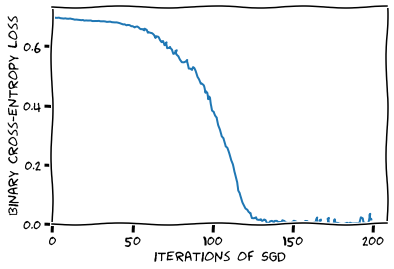

In [ ]:
# Initialize deep CNN and train it
net = DeepCNN()
with plt.xkcd():
  train(net)

## Test

### Test with center surround grating dataset

In [ ]:
def test(net):
  n_iter = 10  # number of iterations of test
  batch_size = 100  # number of data points in each mini-batch

  # Loop over iterations
  for i in range(n_iter):

      # Sample minibatch of oriented grating stimuli
      stimuli, tilt = test_sample_stimuli(batch_size)

      # Evaluate loss and update network weights
      out = net(stimuli)  # predicted probability of tilt right

      
      print('iteration %i | percent correct: (out)%.2f%%, (in)%.2f%%' 
          % (i + 1, 100 * pcorrect(out, tilt)[0], 100 * pcorrect(out, tilt)[1]))
  return out



main function for test

iteration 1 | percent correct: (out)77.00%, (in)0.00%
iteration 2 | percent correct: (out)78.00%, (in)0.00%
iteration 3 | percent correct: (out)65.00%, (in)0.00%
iteration 4 | percent correct: (out)81.00%, (in)0.00%
iteration 5 | percent correct: (out)80.00%, (in)0.00%
iteration 6 | percent correct: (out)80.00%, (in)0.00%
iteration 7 | percent correct: (out)79.00%, (in)0.00%
iteration 8 | percent correct: (out)80.00%, (in)0.00%
iteration 9 | percent correct: (out)73.00%, (in)0.00%
iteration 10 | percent correct: (out)73.00%, (in)0.00%


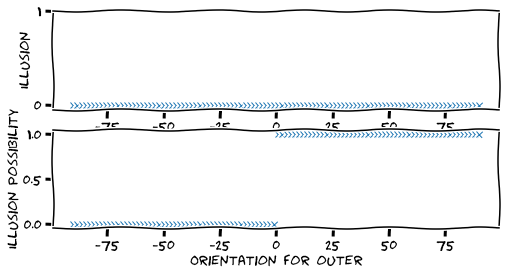

In [ ]:
# get test outcome
out = test(net)
out_tilt = (out > 0.5).type(torch.float)
out_tilt = out_tilt.type(torch.float32)

# plot figure
with plt.xkcd():
  ori = np.vstack([np.linspace(-np.pi/2, np.pi/2, 100), np.zeros(100)]).T
  illusion = np.zeros(100)
  id_ori_right = (ori[:, 0]>0)
  id_ori_left = (ori[:, 0]<0)
  id_choice_right = (out_tilt[:, 1]==1)
  id_choice_left = (out_tilt[:, 1]==0)
  illusion[np.multiply(id_ori_right, id_choice_left)]=1
  illusion[np.multiply(id_choice_left, id_choice_right)]=1

  poss_out = out.clone().detach()
  poss_out[id_ori_right] = 1 - poss_out[id_ori_right]
  fig, axs = plt.subplots(2, 1, figsize=(8, 4))
  axs[0].plot(np.rad2deg(ori[:, 0]), out_tilt.detach()[:, 1], 'x')
  axs[0].set(ylabel='Illusion', yticks=[0, 1])
  axs[1].plot(np.rad2deg(ori[:, 0]), poss_out[:, 1], 'x')
  axs[1].set(xlabel='Orientation for outer',
            ylabel='Illusion Possibility')
  plt.show()